<a href="https://colab.research.google.com/github/Matheus-Homem/Matheus-Homem/blob/main/notebook/Future_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports

## 0.1. Libraries

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import datetime
import seaborn as sns
!pip install joypy
from joypy import joyplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Colors
viridis = cm.get_cmap('viridis', 12)(0.2)

## 0.2. Loading Data

In [4]:
# Importing data from .csv
item_categories = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/item_categories%20(translated).csv")
items = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/items%20(translated).csv")
sales_train = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/sales_train.csv")
shops = pd.read_csv("https://github.com/Matheus-Homem/future-sales-prediction/raw/main/data/shops%20(translated).csv")

In [5]:
# First row of 'item_categories'
item_categories.loc[0]

item_category_name         PC - Гарнитуры/Наушники
item_category_name_en    PC - Headset / Headphones
item_category_id                                 0
Name: 0, dtype: object

In [6]:
# First row of 'items'
items.loc[0]

item_name                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
item_name_en        Lucky In the power of the puffy (reservoir.) D
item_id                                                          0
item_category_id                                                40
Name: 0, dtype: object

In [7]:
# First row of 'sales_train'
sales_train.loc[0]

date              02.01.2013
date_block_num             0
shop_id                   59
item_id                22154
item_price               999
item_cnt_day               1
Name: 0, dtype: object

In [8]:
# First row of 'shops'
shops.loc[0]

shop_name          !Якутск Орджоникидзе, 56 фран
shop_name_en    ! Yakutsk Ordzhonikidze, 56 fran
shop_id                                        0
Name: 0, dtype: object

## 0.3. Helper Functions

In [52]:
def format_number(data_value,index):
  if data_value >= 1000000:
    formatter = '{:1.1f}M'.format(data_value*0.000001)
  else:
    formatter = '{:1.0f}K'.format(data_value*0.001)
  return formatter

# 1. Data Description

## 1.1. Merging Tables

In [9]:
df1 = pd.merge(items,item_categories,on='item_category_id')
df1 = pd.merge(sales_train,df1,on='item_id')
df1 = pd.merge(df1,shops,on='shop_id')

cols_drop = ['item_name','item_category_name','shop_name']
df1 = df1.drop(cols_drop, axis=1)

df1.rename(columns={'item_name_en': 'item_name',
                   'item_category_name_en': 'item_category_name',
                   'shop_name_en': 'shop_name'},
                   inplace=True)

df1.sample().T

,2482797
date,19.09.2014
date_block_num,20
shop_id,26
item_id,4477
item_price,899
item_cnt_day,1
item_name,LittleBigPlanet 2 Extended Edition (with PS Mo...
item_category_id,19
item_category_name,Games - PS3
shop_name,"Moscow TC ""Area"" (Belyaevo)"


## 1.2. Data Dimensions

In [10]:
print('Number of Rows: {:,}'.format(df1.shape[0]))
print('Number of Columns: ',df1.shape[1])

Number of Rows: 2,935,849
Number of Columns:  10


## 1.3. Data Types

In [11]:
df1.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
shop_name              object
dtype: object

## 1.4. Change Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.5. NA Checking

In [13]:
df1.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

## 1.6. Fillout NA

- None of the columns have null values;

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contacatenate
n = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
n.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']

In [16]:
n

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,date_block_num,0.0,33.0,33.0,14.569911,14.0,9.422986,0.203858,-1.082869
1,shop_id,0.0,59.0,59.0,33.001728,31.0,16.226970,-0.072361,-1.025358
2,item_id,0.0,22169.0,22169.0,10197.227057,9343.0,6324.296277,0.257174,-1.225210
3,item_price,-1.0,307980.0,307981.0,890.853233,399.0,1729.799336,10.750423,445.532826
4,item_cnt_day,-22.0,2169.0,2191.0,1.242641,1.0,2.618834,272.833162,177478.098774
5,item_category_id,0.0,83.0,83.0,40.001383,40.0,17.100756,0.318283,-0.525158


### 1.7.2. Categorical Attributes

In [17]:
# Unique values
cat_attributes.apply(lambda x: x.unique().shape[0])

item_name             21720
item_category_name       84
shop_name                60
dtype: int64

# 2. Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

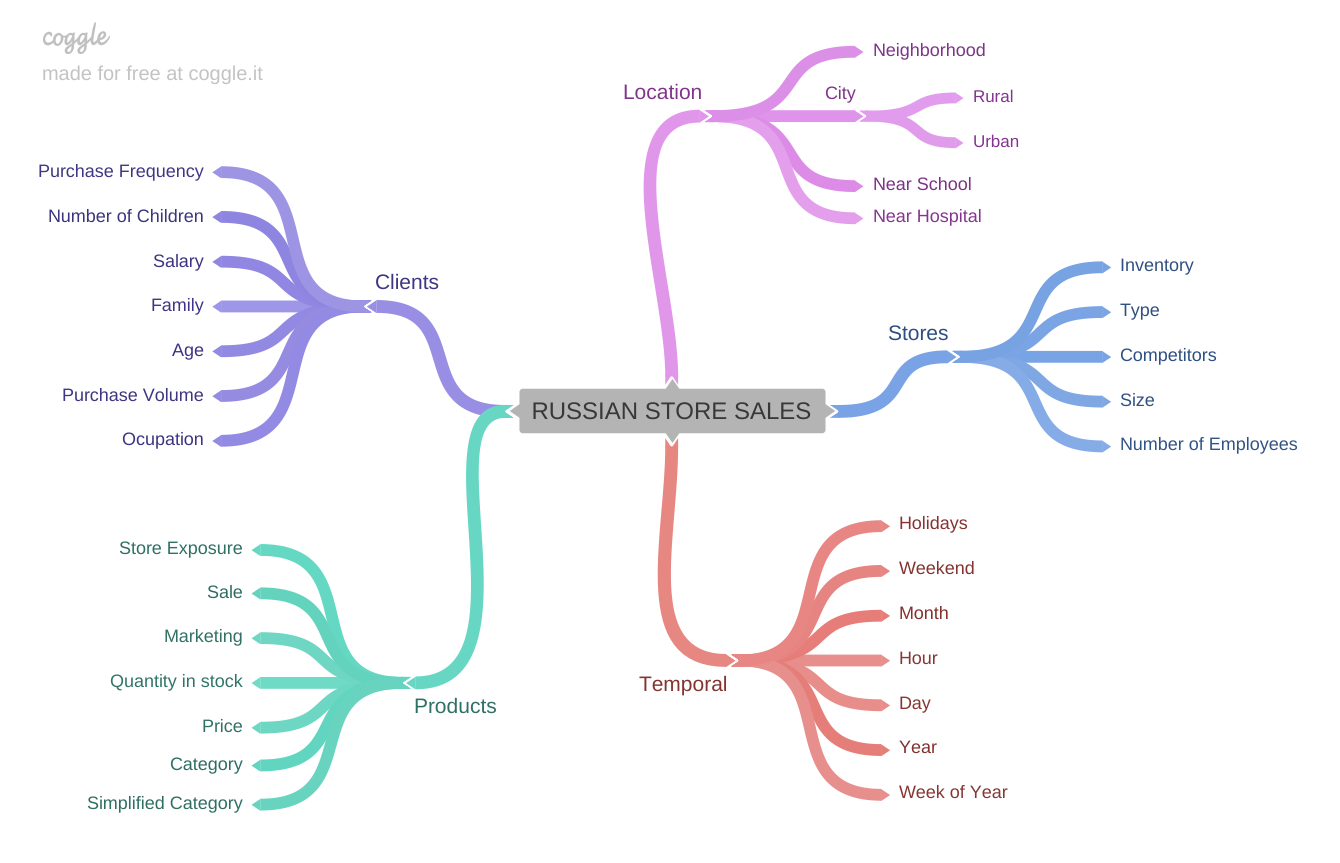

## 2.2. List of Hypothesis

**01.** Stores should sell more over the years

**02.** Stores should sell more in the second semester

**03.** Stores should sell more inthe first half of the month

**04.** Stores should sell less on weekends

**05.** Stores located in Moscow should sell more

**06.** Shopping Center type stores should sell more

**07.** 

**08.** 

**19.** 

## 2.3. Feature Engineering

In [19]:
# Studying item_cnt_day
print('Feature item_cnt_day has {} values equal to 0 and {} values less than 0;'.format(df2[df2['item_cnt_day']==0].shape[0],df2[df2['item_cnt_day']<0].shape[0]))
# Since a store cannot sell negative amounts of items, we will assume that such amounts mean 0
df2['item_cnt_day'] = list(map(lambda x: 0 if x<0 else x, df2['item_cnt_day']))
# As seen in 1.7.1. there are high values for the variable, so we will reduce all outliers above the 99.9 percentile to the 99.9 percentile itself
#sub_percentil = np.percentile(df2['item_cnt_day'], 99.9)
#df2['item_cnt_day'] = list(map(lambda x: sub_percentil if x > sub_percentil else x, df2['item_cnt_day']))

Feature item_cnt_day has 0 values equal to 0 and 7356 values less than 0;


In [20]:
# Grouping item categories
unique_categories = list(df2['item_category_name'].unique())
unique_categories.sort()
simple_categories = list(map(lambda x: x.split('-')[0], unique_categories))
simple_categories = list(map(lambda x: x.split('(')[0].rstrip(), simple_categories))
category_dict = dict(zip(unique_categories, simple_categories))
df2['simple_categories'] = df2['item_category_name'].map(category_dict)

# Extracting city name from shop name
unique_shops = df2['shop_name'].unique()
unique_shops.sort()
cities = unique_shops.copy()
cities[:2] = list(map(lambda x: x[2:],cities[:2]))
cities = list(map(lambda x: x.split(' ')[0],cities))
cities[2] = cities[2][3:]
cities = list(map(lambda x: x.capitalize(),cities))
cities_dict = dict(zip(unique_shops, cities))
df2['city'] = df2['shop_name'].map(cities_dict)

# Extracting shop type from shop name
types_list = list(map(lambda x: x.split()[1], unique_shops))
type_dict = {'"Sale"':'None',
             'Yakutsk':'Shopping Center',
             '(Plekhanovskaya,':'None',
             'MTRC':'TRC',
             'Ordzhonikidze,':'None',
             'Posad':'Shopping Center',
             'Store':'None',
             'TC':'TC',
             'TK':'TK',
             'TPC':'TPC',
             'TRC':'TRC',
             'TRK':'TRK',
             'digital':'Digital',
             'shopping':'Shopping Center',
             'st.':'None',
             'store':'None',
             'trade':'None'}
type_list = [*map(type_dict.get,types_list)]
shop_type_dict = dict(zip(unique_shops, type_list))
df2['shop_type'] = df2['shop_name'].map(shop_type_dict)

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# week in timeline
df2['week_tl'] = df2['date'].sub(df2['date'].min()).dt.days // 7 + 1

# Creating the response variable 'sales' which represents the weekly sale of each store
week_sales_df = df2[['week_tl','shop_name','item_cnt_day']].groupby(['shop_name','week_tl']).sum().reset_index()
week_sales_df['dict'] = week_sales_df['shop_name'] + week_sales_df['week_tl'].astype(str) 
df2['dict'] = df2['shop_name'] + df2['week_tl'].astype(str)
sales_dict = dict(zip(week_sales_df['dict'], week_sales_df['item_cnt_day']))
df2['sales'] = df2['dict'].map(sales_dict)
df2.drop('dict',axis=1,inplace=True)

In [21]:
df2.sample().T

,1329582
date,2013-05-11 00:00:00
date_block_num,10
shop_id,16
item_id,6609
item_price,1149
item_cnt_day,1
item_name,Skylanders. Set of adventure. Secret crypt
item_category_id,25
item_category_name,Games - Accessories for games
shop_name,"Kolomna TC ""Rio"""


# 3. Feature Filtering

In [22]:
df3 = df2.copy()

## 3.1. Rows Filtering

In [23]:
df3 = df3[df3['sales'] > 0]

## 3.2. Columns Filtering

In [24]:
cols_drop = ['shop_id','item_id','item_category_id','date_block_num']
df3.drop(cols_drop,axis=1,inplace=True)
list(df3.columns)

['date',
 'item_price',
 'item_cnt_day',
 'item_name',
 'item_category_name',
 'shop_name',
 'simple_categories',
 'city',
 'shop_type',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'week_tl',
 'sales']

# 4. Exploratory Data Analysis (EDA)

In [26]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

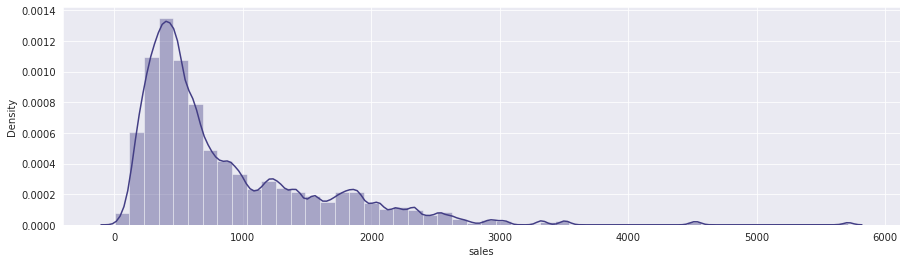

In [27]:
#@title Distribution Plot of Sales Variable
plt.figure(figsize=(15,4))
sns.distplot(df4['sales'],color=viridis)
plt.show()

In [91]:
def monthly_sales(df2):    
    data = df2.copy()     
    # Drop the day indicator from the date column    
    data.date = data.date.apply(lambda x: str(x)[:7])     
    # Sum sales per month    
    data = data.groupby('date')['sales'].sum().reset_index()    
    data.date = pd.to_datetime(data.date)   
    return data

monthly_data = monthly_sales(df2)

In [94]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()    
    data = data.dropna()      
    return data
stationary_df = get_diff(monthly_data)

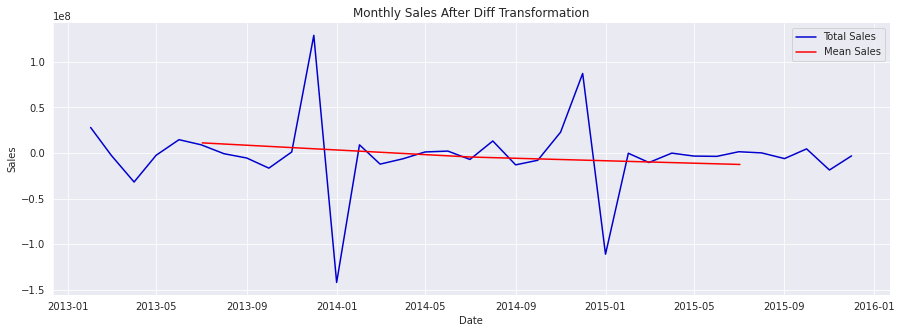

In [98]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

### 4.1.2. Numerical Variables

In [28]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

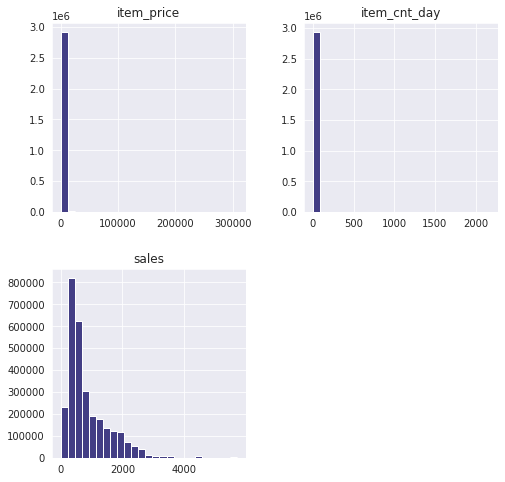

In [29]:
#@title Histograms of all Original Numerical Variables
num_attributes.hist(bins=25,figsize=(8,8),color=viridis);

### 4.1.3. Categorical Variables

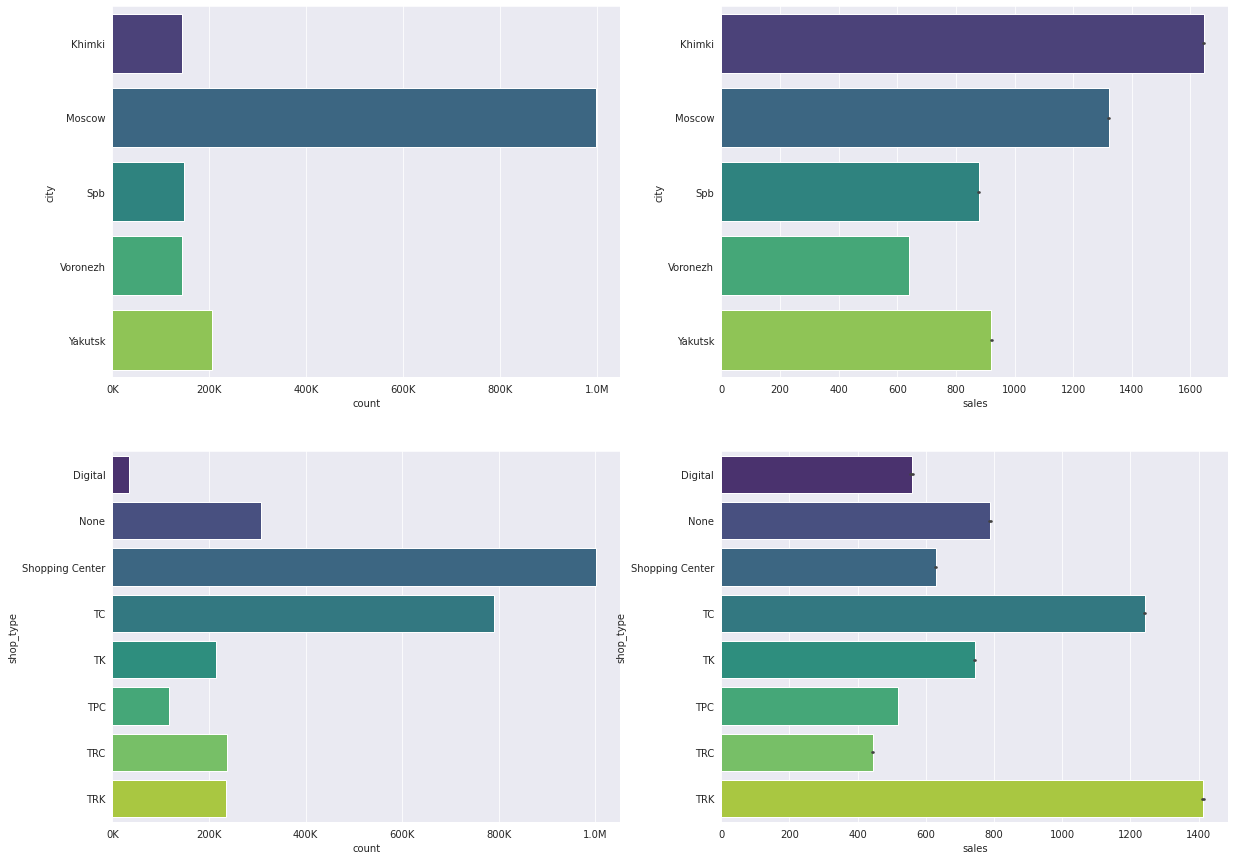

In [56]:
#@title Barplot and countplot for most frequent cities and shop_types
f, axes = plt.subplots(2,2,figsize=(18,15))
formatter = FuncFormatter(format_number)

# city
aux1 = sorted(list(df4['city'].value_counts().index)[:5])
sns.countplot(y=df4[df4['city'].isin(aux1)]['city'],
              order=aux1,
              palette='viridis',
              ax=axes[0,0])
axes[0,0].xaxis.set_major_formatter(formatter)

sns.barplot(data=df4[df4['city'].isin(aux1)],
            y='city',
            x='sales',
            palette='viridis',
            order=aux1,
            ax=axes[0,1])

# shop_type
aux2 = sorted(list(df4['shop_type'].unique()))
sns.countplot(y=df4['shop_type'],
              order=aux2,
              palette='viridis',
              ax=axes[1,0])
axes[1,0].xaxis.set_major_formatter(formatter)

sns.barplot(data=df4,
            y='shop_type',
            x='sales',
            palette='viridis',
            order=aux2,
            ax=axes[1,1])

f.tight_layout()
plt.show()

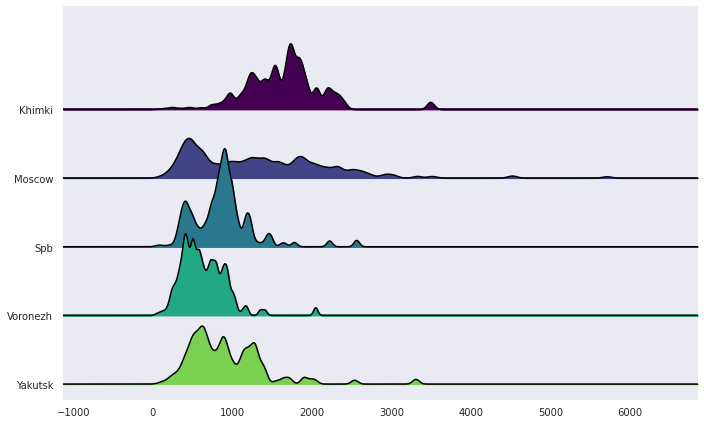

In [31]:
#@title Ridgeline Plot of Sales in different cities
joyplot(
    data=df4[df4['city'].isin(aux1)][['sales','city']],
    by='city',
    colormap=plt.cm.viridis,
    figsize=(10,6))

plt.show()

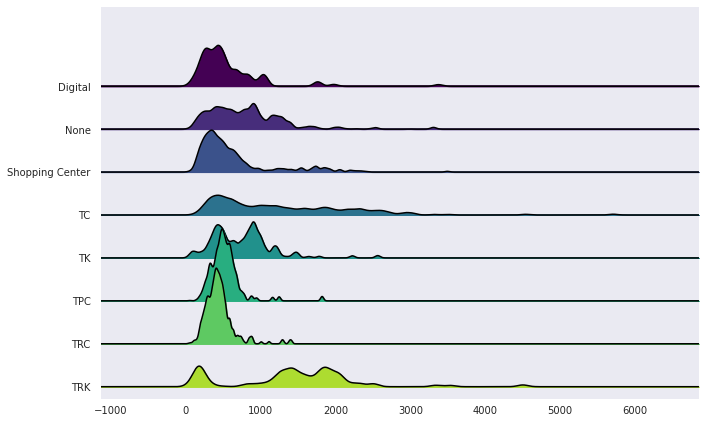

In [32]:
#@title Ridgeline Plot of Sales in different shop types
joyplot(
    data=df4[['sales','shop_type']],
    by='shop_type',
    colormap=plt.cm.viridis,
    figsize=(10,6))

plt.show()

## 4.2. Bivariate Analysis

### $H_{1}:$ Stores should sell more over the years